In [1]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling_seg import ActiveTestVisionTransformer, CONFIGS

from utils.data_utils_feature import *

def read_one_results(path):
    with open(path, "r") as outfile:
        data = json.load(outfile)
    return data

def write_one_results(json_data, path):
    with open(path, "w") as outfile:
        json.dump(json_data, outfile)

In [2]:
%%capture
config = CONFIGS["ViT-B_8"]
config.input_feature_dim = 25
model = ActiveTestVisionTransformer(config, num_classes=50, zero_head=False, img_size=240, vis=True)
model_checkpoint = "./output/ViT-output-PSPNet-VOC-train-ordinal-image-split-2x2_checkpoint_8000.bin"
model.load_state_dict(torch.load(model_checkpoint))
model.eval()

In [3]:
split = "val"
model_data_path = "/workspace/pytorch-segmentation/pro_data/PSPNet_VOC/"
annotation_dir = model_data_path + split + "/image_split_2_2_true_losses.npy"
inputs_path = model_data_path + split
train_loader = FeatureDataset(inputs_path, annotation_dir, aug=False)

In [5]:
estimate_loss_list = None
for i in range(1449*4):
    feature, label = train_loader.__getitem__(i)
    patch_loss_estimation = model.forward_patch_result(feature.unsqueeze(0))
    estimated_loss = tensor_ordinal_to_float_patch(patch_loss_estimation)
    estimated_loss = estimated_loss.numpy()
    if estimate_loss_list is None:
        estimate_loss_list = estimated_loss
    else:
        estimate_loss_list = np.concatenate((estimate_loss_list, estimated_loss))
    if (i+1)%100 == 0:
        print(f"Process {i}")

Process 99
Process 199
Process 299
Process 399
Process 499
Process 599
Process 699
Process 799
Process 899
Process 999
Process 1099
Process 1199
Process 1299
Process 1399
Process 1499
Process 1599
Process 1699
Process 1799
Process 1899
Process 1999
Process 2099
Process 2199
Process 2299
Process 2399
Process 2499
Process 2599
Process 2699
Process 2799
Process 2899
Process 2999
Process 3099
Process 3199
Process 3299
Process 3399
Process 3499
Process 3599
Process 3699
Process 3799
Process 3899
Process 3999
Process 4099
Process 4199
Process 4299
Process 4399
Process 4499
Process 4599
Process 4699
Process 4799
Process 4899
Process 4999
Process 5099
Process 5199
Process 5299
Process 5399
Process 5499
Process 5599
Process 5699


In [6]:
store_path = "./output/region_8_8_split/ViT-output-PSPNet-VOC-train-ordinal-image-split-2x2_losses_8000.json"
json_object = {"losses":estimate_loss_list.tolist()}
write_one_results(json_object, store_path)

In [26]:
def display_one_sample_result(index):
    feature, label = train_loader.__getitem__(index)
    patch_loss_estimation = model.forward_patch_result(feature.unsqueeze(0))
    estimated_loss = tensor_ordinal_to_float_patch(patch_loss_estimation)
    estimated_loss = estimated_loss.numpy()
    print("Estimate")
    plt.matshow(patch_loss_estimation.argmax(dim=1).reshape(30,30))
    plt.colorbar()
    plt.show()
    print("Label")
    plt.matshow(label[1:].reshape(30,30))
    plt.colorbar()
    plt.show()

Estimate


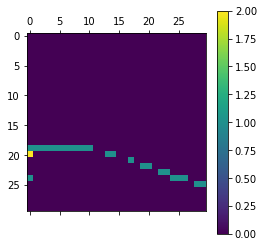

Label


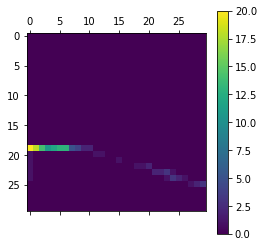

In [27]:
display_one_sample_result(0)

Estimate


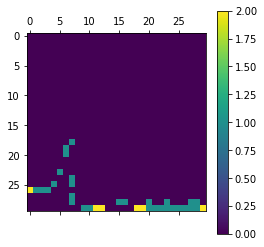

Label


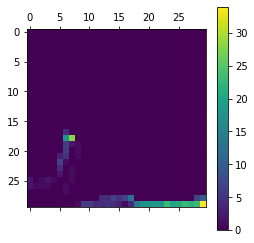

In [28]:
display_one_sample_result(1)

Estimate


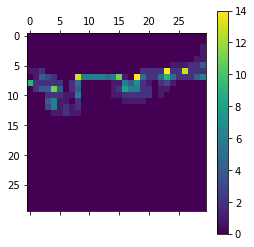

Label


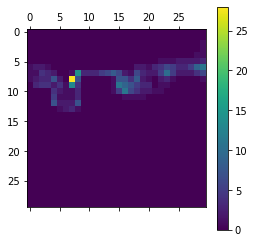

In [29]:
display_one_sample_result(2)

Estimate


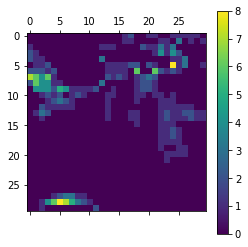

Label


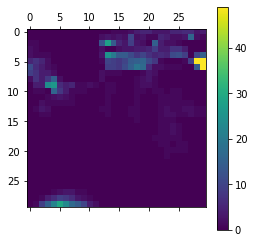

In [30]:
display_one_sample_result(3)

Estimate


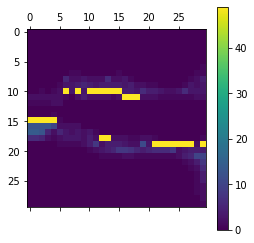

Label


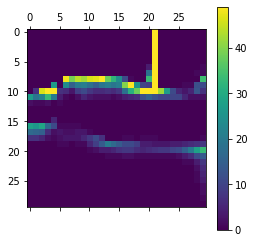

In [31]:
display_one_sample_result(11)